In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler


In [2]:
irisDataset = load_iris()

In [16]:
X = irisDataset.data
y = irisDataset.target
features = irisDataset.feature_names
classes = irisDataset.target_names

In [9]:
print(irisDataset.DESCR)


Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [5]:
# Dataset looks clean. No missing values. No outliers. Lets plot LDA and PCA with 2 components 
# and see how overlapping the classes are.

In [10]:
#Normalize data.
scaler = MinMaxScaler(feature_range = (0,1))
X = scaler.fit_transform(X)

/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


explained variance ratio (first two components): [ 0.92461621  0.05301557]


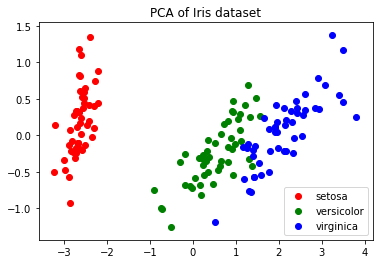

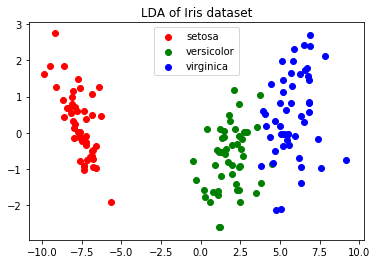

In [13]:
from sklearn.decomposition import PCA
from sklearn.lda import LDA

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], classes):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of Iris dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], classes):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of Iris dataset')

plt.show()

In [8]:
#Clear distinction between 2 classes. Classification should have good results

Optimal number of features : 4


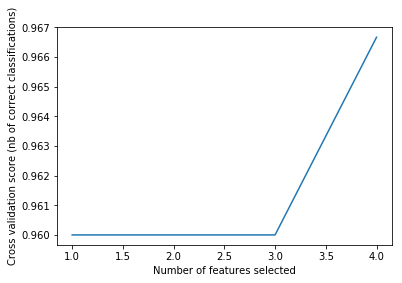

In [14]:
#Feature selection
#Recursive feature elimination with Cross validation

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
ranks = rfecv.ranking_

rfe_selected_features = [feature for feature,rank in zip(features,ranks) if rank == 1]
rfe_discarded_features = [feature for feature,rank in zip(features,ranks) if rank != 1]

print("Features selected by RFECV are\n")
print(rfe_selected_features)
print("\nFeatures discarded by RFECV are\n")
print(rfe_discarded_features)

Features selected by RFECV are

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Features discarded by RFECV are

[]


In [20]:
#Lets see what the top 2 and top 3 features are
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

top = [2,3]
for i in top:
    selectkbest = SelectKBest(chi2, k=i)
    X_new = selectkbest.fit_transform(X, y)
    kbest_selected_features = [feature for feature,selection in 
                               zip(features,selectkbest.get_support()) if selection == True]
    kbest_discarded_features = [feature for feature,selection in 
                               zip(features,selectkbest.get_support()) if selection == False]

    print("Top ",i," Features selected by selectKBest are\n")
    print("\t\t",kbest_selected_features)
    print("\nFeatures discarded by selectKBest are\n")
    print("\t\t",kbest_discarded_features)
    print("===============================")

#Lets see the scores to get a better picture
print("\nScores for all the features are:")
for feature,score in zip(features,selectkbest.scores_):
    print('%25s  \t - \t %f' % (feature,score) )

Top  2  Features selected by selectKBest are

		 ['petal length (cm)', 'petal width (cm)']

Features discarded by selectKBest are

		 ['sepal length (cm)', 'sepal width (cm)']
Top  3  Features selected by selectKBest are

		 ['sepal length (cm)', 'petal length (cm)', 'petal width (cm)']

Features discarded by selectKBest are

		 ['sepal width (cm)']

Scores for all the features are:
        sepal length (cm)  	 - 	 10.817821
         sepal width (cm)  	 - 	 3.594499
        petal length (cm)  	 - 	 116.169847
         petal width (cm)  	 - 	 67.244828


In [12]:
#Chi2 values paint a slightly different picture compared to RFECV
# Sepal width doesn't seem to be infuencing the target much.
# But I will use all 4 features.